# Imports

In [24]:
import os
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt


# Variables

In [25]:
BATCH_SIZE = 32
EPOCHS = 10
IMG_SIZE = (160, 160)
SEED = 42

train_dir = pathlib.Path("/Users/leonardo/Documents/Projects/cryptovision/data/processed/train")
test_dir = pathlib.Path("/Users/leonardo/Documents/Projects/cryptovision/data/processed/test")
val_dir = pathlib.Path("/Users/leonardo/Documents/Projects/cryptovision/data/processed/valid")

# Setup Dataset

In [59]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

Found 5789 files belonging to 57 classes.
Found 1448 files belonging to 57 classes.
Found 1810 files belonging to 57 classes.


# View Some Images

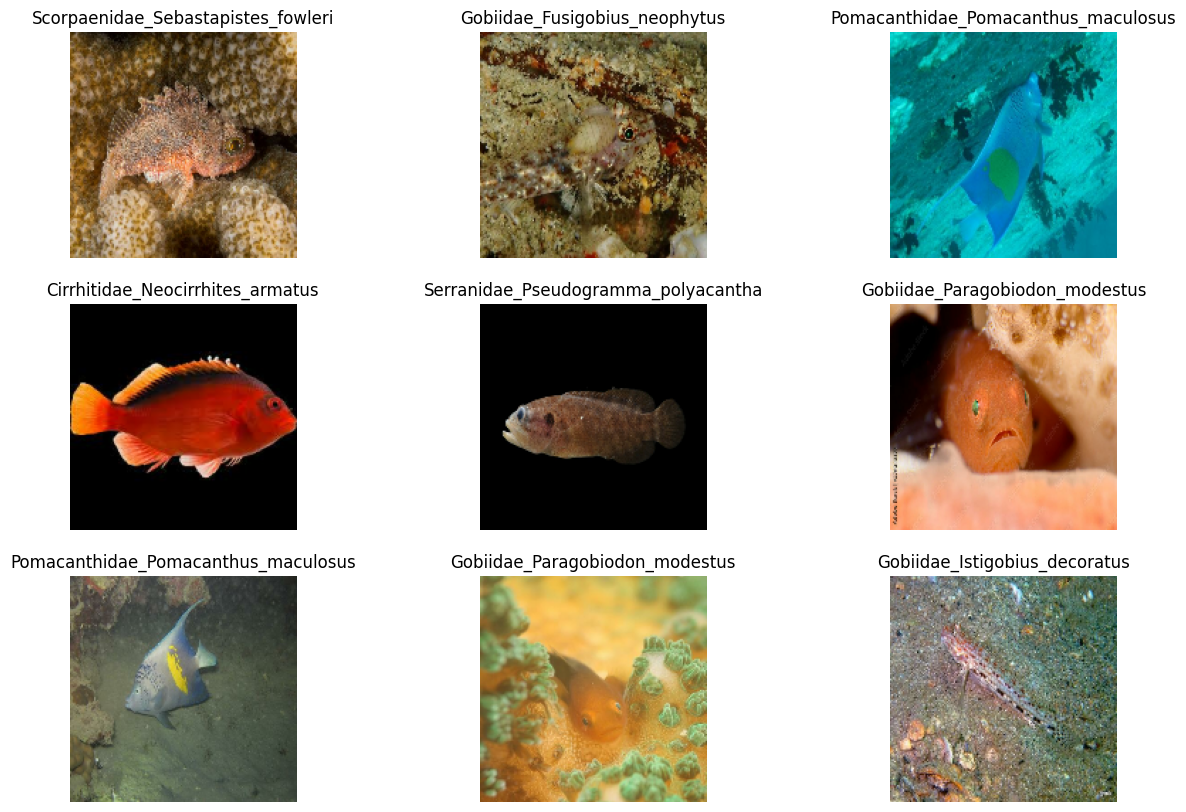

In [27]:
class_names = train_ds.class_names

plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# AutoTune Dataset

In [28]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

In [39]:
# Data Augmentation Function
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
        #tf.keras.layers.GaussianNoise(0.2),
    ]
)

## View Augmented Images

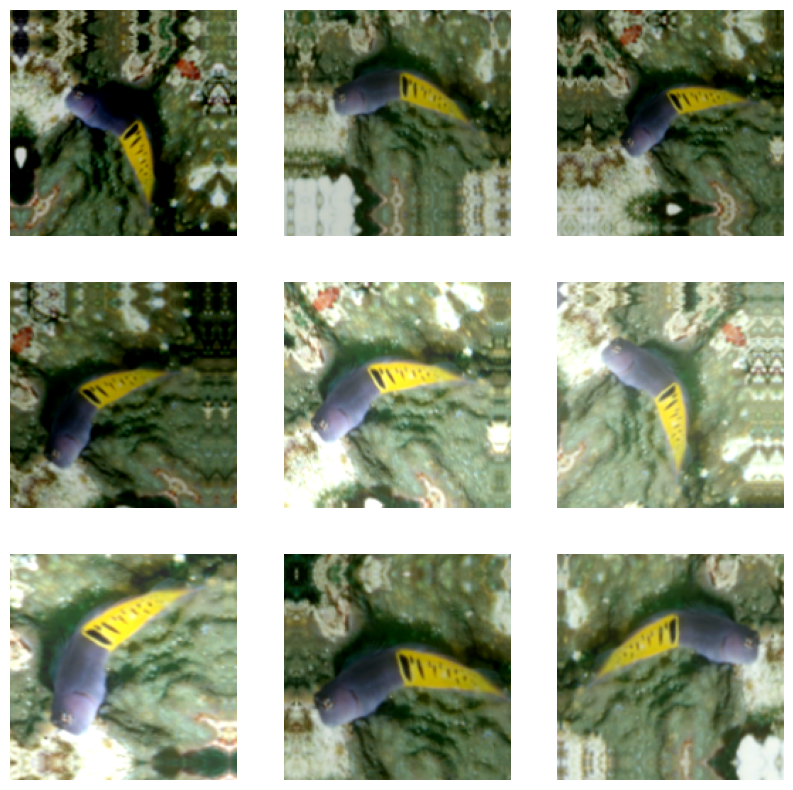

In [40]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [43]:
# MobileNetV2 Image Preprocessing
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Create Base Model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

In [44]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [50]:
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs) 
x = preprocess_input(x) 
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(57, activation='softmax', name='output')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_3 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_3 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 57)             │        73,017 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,331,001 (8.89 MB)

 Trainable params: 73,017 (285.22 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [63]:
base_learning_rate = 0.0001
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
  loss="categorical_crossentropy", 
  metrics=['accuracy'],
)

In [65]:
loss0, accuracy0 = model.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.0142 - loss: 4.6841
initial loss: 4.66
initial accuracy: 0.02


In [66]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.0518 - loss: 4.3485 - val_accuracy: 0.1823 - val_loss: 3.3389
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.1978 - loss: 3.2677 - val_accuracy: 0.3605 - val_loss: 2.6919
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.3361 - loss: 2.6631 - val_accuracy: 0.4655 - val_loss: 2.2631
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.4411 - loss: 2.2581 - val_accuracy: 0.5380 - val_loss: 1.9761
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - accuracy: 0.5106 - loss: 2.0078 - val_accuracy: 0.5794 - val_loss: 1.7693
Epoch 6/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.5653 - loss: 1.7838 - val_accuracy: 0.6126 - val_loss: 1.6116
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.5897 - loss: 1.6566 - val_accuracy: 0.6416 - val_loss: 1.4905
Epoch 8/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - accuracy: 0.6307 - loss: 1.4959 - 

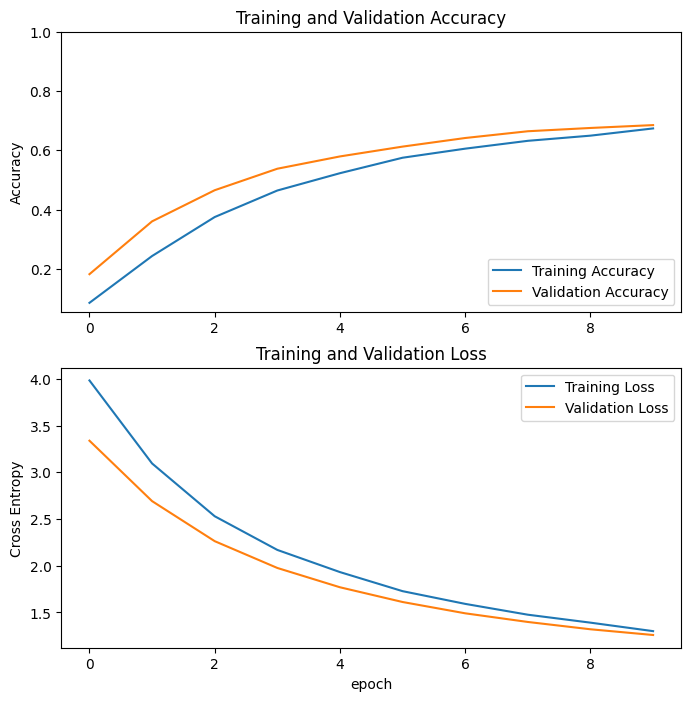

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tuning

In [70]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [71]:
model.compile(
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
  loss="categorical_crossentropy", 
  metrics=['accuracy'],
)

In [72]:
fine_tune_epochs = 10
total_epochs =  EPOCHS + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=val_ds)

Epoch 11/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 39s 159ms/step - accuracy: 0.5081 - loss: 1.8965 - val_accuracy: 0.7003 - val_loss: 1.1398
Epoch 12/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 25s 138ms/step - accuracy: 0.6139 - loss: 1.5006 - val_accuracy: 0.7141 - val_loss: 1.0499
Epoch 13/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 25s 136ms/step - accuracy: 0.6808 - loss: 1.2572 - val_accuracy: 0.7286 - val_loss: 0.9773
Epoch 14/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 25s 137ms/step - accuracy: 0.7043 - loss: 1.1630 - val_accuracy: 0.7459 - val_loss: 0.9143
Epoch 15/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 25s 137ms/step - accuracy: 0.7237 - loss: 1.0457 - val_accuracy: 0.7583 - val_loss: 0.8649
Epoch 16/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 25s 138ms/step - accuracy: 0.7367 - loss: 1.0046 - val_accuracy: 0.7673 - val_loss: 0.8232
Epoch 17/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 27s 147ms/step - accuracy: 0.7537 - loss: 0.9309 - val_accuracy: 0.7762 - val_loss: 0.7834
Epoch 18/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 26s 144ms/step - accuracy: 0.7633 -

In [73]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

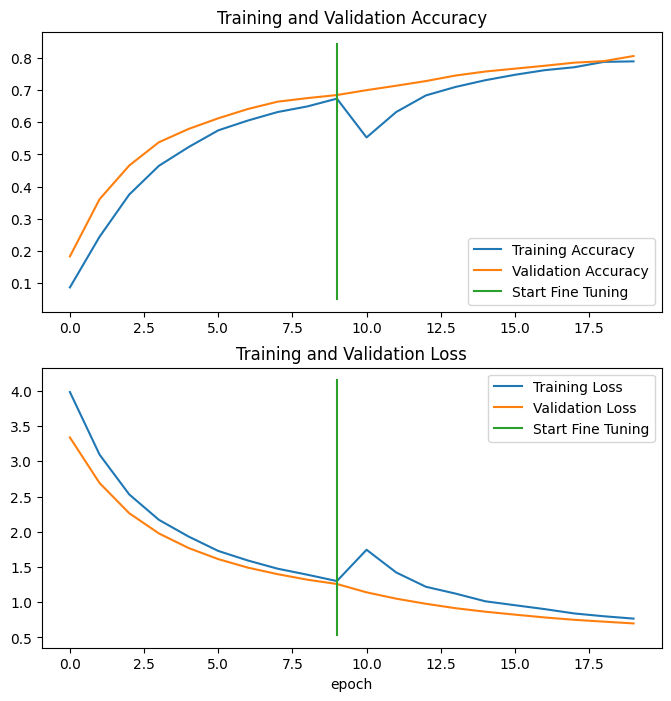

In [75]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [78]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8245 - loss: 0.6992
Test accuracy : 0.8104972243309021
